# Homework 13

Please complete all core assignment tasks (marked "TASK"). For bonus points, please complete the optional stretech assignment tasks (marked "OPTIONAL").

The goals of this HW include the following:
* Understanding the operation of a multiclass perceptron classifier.
* Building a multiclass perceptron classifier.
    * Applying regularization
    * Evaluating performance metrics unique to a multiclass problem.
* Tuning a multiclass perceptron for text classification.
  
You will submit the results of your work in this notebook using the **HW 13 Submission Form** assignment on Canvas.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re
import nltk
from pprint import pprint
from time import time

from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.datasets import make_classification
from nltk.corpus import stopwords, reuters
nltk.download('stopwords')
nltk.download('reuters')

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/jamie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package reuters to /Users/jamie/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


# TASK: Discuss the most important feature

Compare the hyperplane coefficients barchart with the pairwise visualization and complete the analysis provided below.

## Load the data and build a perceptron classifier model

In [20]:

irisDataset = load_iris() 


X = irisDataset.data
y = irisDataset.target

#create a heldout dataset for final testing only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df = pd.DataFrame(X, columns=irisDataset.feature_names)
df['IrisClass'] = y

perceptron_pipeline = Pipeline([
        #('imputer', Imputer(strategy="median")), #Use the "median" to impute missing vlaues
        ('std_scaler', StandardScaler()),
        ('perceptron', Perceptron(random_state=42))
    ])

perceptron_pipeline.fit(X_train, y_train)
preds = perceptron_pipeline.predict(X_test)

### Generate visualizations (pairwise scatterplot and bar chart of the model coefficients)

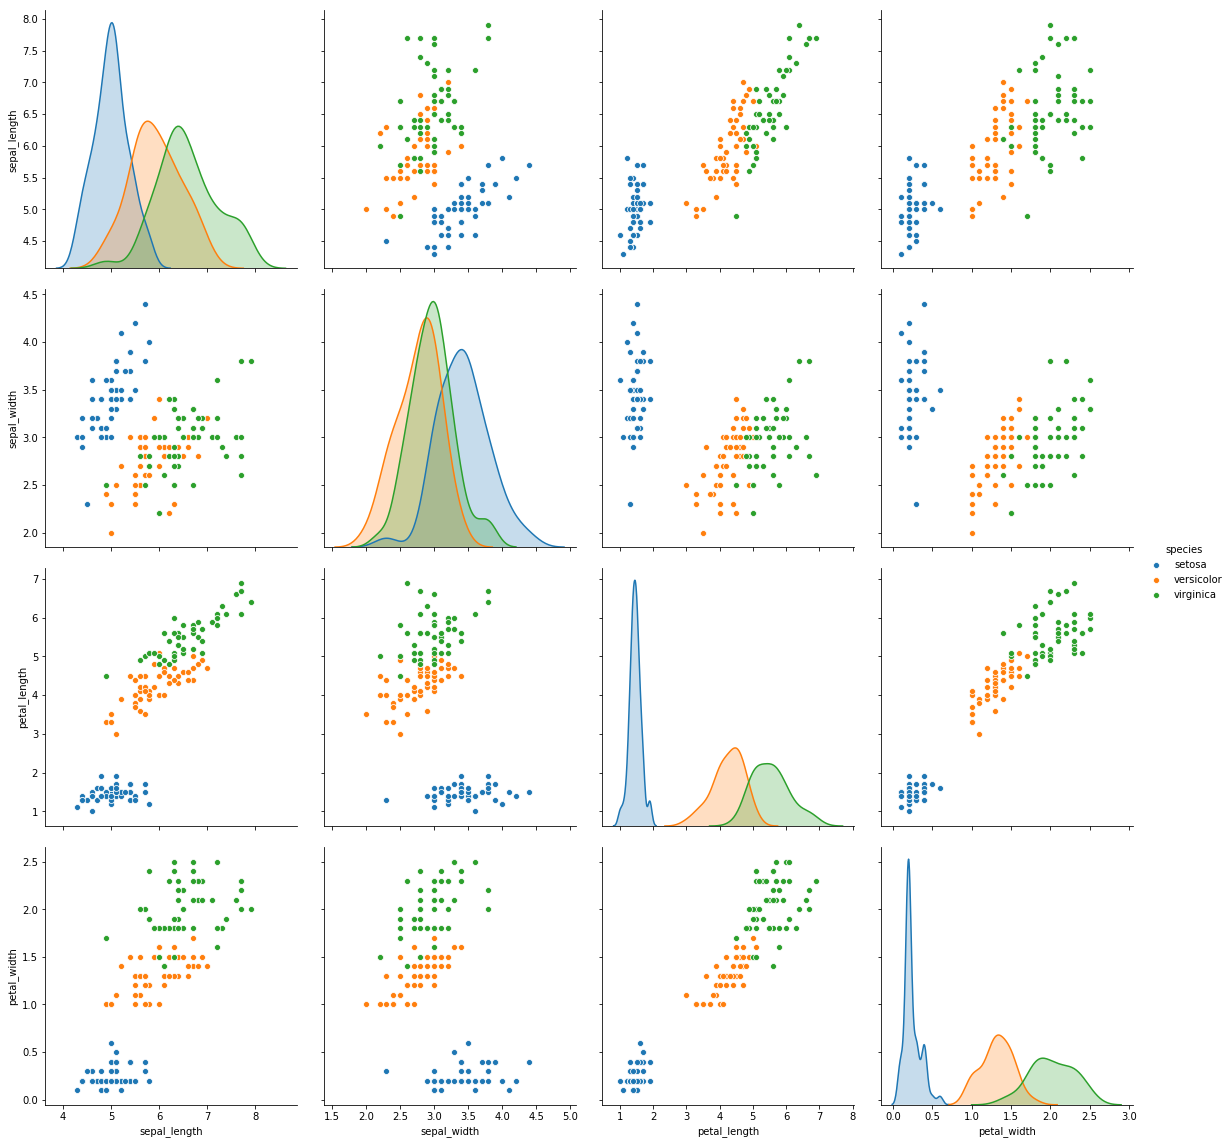

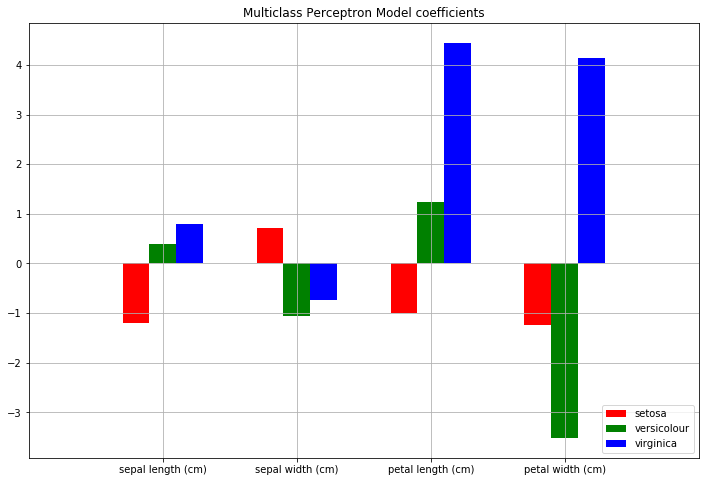

In [22]:
sns.pairplot(sns.load_dataset("iris"), hue="species", height=4);

model = perceptron_pipeline.named_steps['perceptron']
plt.figure(figsize=(12, 8))
plt.bar(np.arange(model.coef_.shape[1]) - 0.2, model.coef_[0], color="red", width=0.2, label="setosa")
plt.bar(np.arange(model.coef_.shape[1]) - 0.0, model.coef_[1], color="green", width=0.2, label="versicolour")
plt.bar(np.arange(model.coef_.shape[1]) + 0.2, model.coef_[2], color="blue", width=0.2, label="virginica")
plt.xticks(np.arange(model.coef_.shape[1]), df.columns, rotation=0)
plt.xlim([-1, model.coef_.shape[1]])
plt.title("Multiclass Perceptron Model coefficients")
plt.legend(loc="lower right");
plt.grid()


**Fill in the appropriate text:**

Compare the hyperplane cooefficients barplot above with the pairwise feature distributions plotted previously.

Looking at the barplot, one can see that ____________ has the least influence on defining a separating hyperplane for the versicolour class.  Looking at the the pairwise plot, this feature does not distinguish versicolour in combination with any other feature.

Looking at the second column on the pairwise plot, virginica and versicolor classes are both impossible to distinguish based on ____________; we can observe that 99% of the vertical lines that can be drawn, contain more than one class and hence wont be able to separate classes based on this feature.

Both petal width and petal length are excellent features to consider since either one can separate 100% of ____________.  In combination, they are able to separate close to 100% of the remaining classes too. ____________  is the most influential factor in determining ____________ class. This is also clearly visible in the pairwise plot, as 99% of the vertical lines clearly indicate exactly one class.

# TASK: Multiclass  perceptron with regularization

Using the SKLearn class `SGDClassifier` within the pipeline provided below, learn multiclass perceptron using gridsearch to evaluate:
* L1, L2 and elasticnet regularization
* alpha values $\in [10, 1, 0.1, 0.01, 0.001)$

Report your the accuracy score on your test data and the hyperparameters for your best model.

In [ ]:
# generate classification dataset
x, y = make_classification(1000, n_classes=3, n_informative=6, random_state=42)

# generate splits for crossfold validation
cv = KFold(3, random_state=42)
cv_idx = cv.split(x)

pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
        ('perceptron', SGDClassifier(loss= *** FILL IN CODE HERE ***  , random_state=42))
    ])

parameters = { 

  ('alpha': 10)
    
}


grid_search = GridSearchCV(pipeline, parameters, cv=cv_idx, n_jobs=-1, verbose=1)
grid_search.fit(x,y)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
preds = grid_search.predict(x)
accuracy = accuracy_score(preds, y)

results = pd.DataFrame(columns=["Model", "Test Accuracy"])
results.loc[len(results)] = ["Perceptron", np.round(accuracy, 3)]
results

# Calculate F1 score with micro and macro averaging




### Equation  $F_1$ score

$
F_1 = \cfrac{2}{\cfrac{1}{\text{precision}} + \cfrac{1}{\text{recall}}} = 2 \times \cfrac{\text{precision}\, \times \, \text{recall}}{\text{precision}\, + \, \text{recall}} = \cfrac{TP}{TP + \cfrac{FN + FP}{2}}
$





So for our Reuters multiclass classification problem the labels are not binary, but are one-hot encoded. Fortunately, there are  options that work with this type of labeled  data for Precision:

* precision_score(y_test, y_pred, average=None) will return the precision scores for each class, while
* precision_score(y_test, y_pred, average='micro') will return the total ratio of tp/(tp + fp)
* precision_score(y_test, y_pred, average='macro') will return macro average (class average = sum(precision)/numOfClasses). This is option is much preferred which dealing with imbalanced data.

The same is true for other performance measures such as F1.

### Run this code to generate targets and predictions

In [7]:
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
import numpy as np


_, y1 = make_classification(n_samples=20, n_features=100, n_informative=30, n_classes=5, random_state=12)
y2 = shuffle(y1, random_state=1)
y3 = shuffle(y1, random_state=2)
y4 = shuffle(y1, random_state=3)


y_text = np.vstack((y1, y2, y3, y4)).T

# One hot encode the target class variables
mlb = MultiLabelBinarizer(classes=(0, 1, 2, 3, 4))
y = mlb.fit_transform(y_text)


_, y1 = make_classification(n_samples=20, n_features=100, n_informative=30, n_classes=5, random_state=42)
y2 = shuffle(y1, random_state=1)
y3 = shuffle(y1, random_state=2)
y4 = shuffle(y1, random_state=3)
y5 = shuffle(y1, random_state=4)

#NOTE: Y target vector for 3 classes
# note that each example can have one or MORE class labels
y_preds_text = np.vstack((y1, y2, y3, y4, y5)).T     
# One hot encode the target class variables
mlb = MultiLabelBinarizer(classes=(0, 1, 2, 3, 4))
y_preds = mlb.fit_transform(y_preds_text)

### These are the 20 multilabel targets:

In [8]:
print(y)

[[1 1 0 1 1]
 [0 1 1 1 0]
 [1 1 1 1 0]
 [1 1 0 1 0]
 [0 1 1 0 0]
 [1 0 0 1 1]
 [1 1 0 1 0]
 [1 1 0 0 1]
 [0 0 1 1 1]
 [0 1 1 1 0]
 [1 0 1 1 1]
 [1 1 0 1 0]
 [1 1 0 0 1]
 [0 1 1 1 0]
 [0 1 1 1 1]
 [1 0 1 0 0]
 [1 0 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [1 0 1 0 0]]


### These are the 20 predictions generated by our "model":

In [9]:
print(y_preds)

[[1 1 0 1 1]
 [1 1 1 1 1]
 [1 1 1 1 0]
 [1 1 0 1 1]
 [1 1 1 0 0]
 [1 1 1 1 0]
 [1 0 1 0 1]
 [0 1 1 1 0]
 [1 1 1 1 0]
 [1 1 1 1 1]
 [1 0 1 1 0]
 [1 0 0 1 1]
 [1 1 1 1 0]
 [1 1 1 0 0]
 [1 0 1 1 1]
 [1 1 1 1 0]
 [1 1 0 0 0]
 [1 1 0 1 0]
 [0 1 1 1 1]
 [0 1 0 1 0]]


## TASK: Calculate F1 scores
Using the one-hot encorded targets and predictions data above (for 20 multi-label samples) calculate the F1 score using micro and macro averaging.

# [Optional Task] Reuters classification with different k

Using the code provided below, generate a series of experiments based on the Reuters dataset:

At a minimum:
* Try running the Reuters classification experiments for 30, 50, and 90 classes.
* Compare the perceptron algorithm to logistic regression ("log" loss). 
* Experiment with unigrams and bigrams.
* Experiment with at least two more hyperparameters.

Keep a log of your results for each experiment in a table of results (pandas dataframe).  Your table of results should be a meaningful record or your work on this task, not a dump of grid search output for one experiment.  Please include:
* Description of the model (e.g., Baseline Logistic Regression k=30, Perceptron k=50, etc.).
* Identify key hyperparameters.
* Precision, recall and F1 scores calculated using micro and macro approach.
* Time to complete the experiment.
* Hardware used.

Think about how (and why) these changes affect your results.

In [ ]:
cachedStopWords = nltk.corpus.stopwords.words('english')

def loadReutersTrainTest():
    documents = reuters.fileids()
    train_docs_id = list(filter(lambda doc: doc.startswith("train"), documents))
    test_docs_id = list(filter(lambda doc: doc.startswith("test"), documents))
    #Input text
    train_docs = [reuters.raw(doc_id) for doc_id in train_docs_id]
    test_docs = [reuters.raw(doc_id) for doc_id in test_docs_id]
    #Categories 
    train_target_names = [reuters.categories  (doc_id) for doc_id in train_docs_id]
    test_target_names = [reuters.categories  (doc_id) for doc_id in test_docs_id]

    return(train_docs, test_docs, train_target_names, test_target_names)

train_docs, test_docs, train_target_names, test_target_names = loadReutersTrainTest()

# create counter to summarize
categories = []
file_count = []

# count each tag's number of documents
for i in reuters.categories():
    """print("$ There are {} documents included in topic \"{}\""
          .format(len(reuters.fileids(i)), i))"""
    file_count.append(len(reuters.fileids(i)))
    categories.append(i)

# create a dataframe out of the counts
allCategories = df = pd.DataFrame(
    {'categories': categories, "file_count": file_count}) \
    .sort_values('file_count', ascending=False)

In [ ]:
# determines number of categories
k=10

# Select documents that only contains top two labels with most documents
category_filter = df.iloc[0:k, 0].values.tolist()

In [ ]:
#load examples for top K classes
def loadReutersTrainTestTopFiltered(category_filter):
    # select fileid with the category filter
    documents = reuters.fileids()

    doc_list = np.array(reuters.fileids(category_filter))
    doc_list = doc_list[doc_list != 'training/3267']

    train_docs_id = list(filter(lambda doc: doc.startswith("train"), doc_list))
    test_docs_id = list(filter(lambda doc: doc.startswith("test"), doc_list))
    #Input text
    train_docs = [reuters.raw(doc_id) for doc_id in train_docs_id]
    test_docs = [reuters.raw(doc_id) for doc_id in test_docs_id]
    #Categories 
    train_target_names = [reuters.categories  (doc_id) for doc_id in train_docs_id]
    test_target_names = [reuters.categories  (doc_id) for doc_id in test_docs_id]
    #remove labels from each example that have not been selected
    # ['earn', 'acq', 'money-fx', 'grain', 'crude', 'trade', 'interest', 'ship', 'wheat', 'corn']
    # E.g., ['Japanese Anime',  'earn', 'acq']  --> ['earn', 'acq'] 
    transformedTags = []
    for tags in train_target_names:
        tagsTmp=[]
        for tag in tags:
            if tag in category_filter:
                tagsTmp.append(tag)
        transformedTags.append(tagsTmp)
    train_target_namesK = transformedTags  
    
    transformedTags = []
    for tags in test_target_names:
        tagsTmp=[]
        for tag in tags:
            if tag in category_filter:
                tagsTmp.append(tag)
        transformedTags.append(tagsTmp)
    test_target_namesK = transformedTags    

    return(train_docs, test_docs, train_target_namesK, test_target_namesK)

train_docs, test_docs, train_target_names, test_target_names = loadReutersTrainTestTopFiltered(category_filter)
mlb = MultiLabelBinarizer(classes=category_filter)
Y_train = mlb.fit_transform(train_target_names)
Y_test = mlb.fit_transform(test_target_names)

print("Number of train docs is ", len(train_docs))
print("Train labels:", Y_train.shape)
print("Number of test docs is ", len(test_docs))
print("Test labels:", Y_train.shape)

In [ ]:
#Multi-labels per example evaluation
def evaluate(test_labels, predictions):
    precision = precision_score(test_labels, predictions, average='micro')
    recall = recall_score(test_labels, predictions, average='micro')
    f1 = f1_score(test_labels, predictions, average='micro')
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

    precision = precision_score(test_labels, predictions, average='macro')
    recall = recall_score(test_labels, predictions, average='macro')
    f1 = f1_score(test_labels, predictions, average='macro')

    print("Macro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    


# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),  #http://scikit-learn.org/stable/modules/feature_extraction.html
    ('tfidf', TfidfTransformer()), 
    ('clf', MultiOutputClassifier(SGDClassifier(loss='log'))),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
# Parameters of the estimators in the pipeline can be accessed using the <estimator>__<parameter> syntax:

parameters = { #listed in the form of "step__parameter", e.g, clf__penalty
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 200,500), 
    #'vect__ngram_range': ((1, 1), (1, 2)), 
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.001, 0.01),        ## access parameters for the estimator inside
    #'clf__estimator__penalty': ('l1'),  ## the MultioutputClassifier step by using
    #'clf__estimator__loss': ('log')     ## step__MultioutputClassierParameter__EstimatorParameter
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    # n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.
    #
    # By default, the GridSearchCV uses a 3-fold cross-validation. However, if it 
    #            detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.
    grid_search = GridSearchCV(pipeline, parameters, cv=2, n_jobs=-1, verbose=1, scoring="f1_macro")

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(train_docs, Y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    #print("grid_search.cv_results_", grid_search.cv_results_)
    #estimator : estimator object. This is assumed to implement the scikit-learn estimator interface.  
    #            Either estimator needs to provide a score function, or scoring must be passed.
    #Accuracy is the default for classification; feel free to change this to precision, recall, fbeta
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    #Test on Heldlout test set
    preds = grid_search.best_estimator_.predict(test_docs)
    print("--------------------------------------------------------------------")
    evaluate(Y_test, preds)


# [Optional Task] Complete the following code to build a Multiclass Perceptron algorithm

Test your classifier using the wine dataset from sklearn.  For your train and test data, report accuracy score, F1 score (micro) and F1 score (macro) in a table of results. 

In [ ]:
import numpy as np


class HomeGrownPerceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [ ]:
import numpy as np


class MulticlassHomeGrownPerceptron(HomeGrownPerceptron):
    """ Multiclass HomeGrown Perceptron classifier."""

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        n_classes = np.unique(y).size
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=(n_classes, 1 + X.shape[1]))
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                predicted = self.predict(xi)
                if target != predicted:  #Mistake
                    #Reduce the score of the incorrectly predicted class
                    self.w_[predicted,1:] -= self.eta * xi
                    self.w_[predicted,0] -= self.eta
                    #increase the score of the true class

                    ******* FILL IN CODE HERE *********
                    ******* TWO LINES OF CODE *********
                    
                    errors += 1
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[:,1:].T) + self.w_[:,0].T
    
    def predict(self, X):
        """Return class label after unit step"""
        if X.ndim == 1:
            return np.argmax(self.net_input(X))
        else:
            return np.argmax(self.net_input(X), axis=1)


In [10]:
wine = load_wine()
data = wine.data
targets = wine.target
target_names = wine.target_names

In [11]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data, targets, test_size=.2, shuffle=True, random_state=42)

print('Train: {}   {}'.format(Xtrain.shape, ytrain.shape))
print('Test: {}   {}'.format(Xtest.shape, ytest.shape))

Train: (142, 13)   (142,)
Test: (36, 13)   (36,)


In [12]:
vals = np.unique(ytrain)
print('Train data')
for v in vals:
    print('{}: {}'.format(target_names[v], np.sum(ytrain == v)))
    
print('\nTest data')
for v in vals:
    print('{}: {}'.format(target_names[v], np.sum(ytest == v)))

Train data
class_0: 45
class_1: 57
class_2: 40

Test data
class_0: 14
class_1: 14
class_2: 8
